# ReadMe

# Imports

In [83]:
# <<< imports >>> -----------------------------------------------------------
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np

# ___________________________________________________________________ <<< >>>


# Variables

In [126]:
# <<< variables >>> ---------------------------------------------------------

paths_dict = {

    # path to the output of the model runs
    # (This is produced by the notebook: ...)
    "svs_output": Path(
        "./output/DailyAveraged_SVS_outputs.csv"
    ),

    # path to percolation observations
    "obs_percolation": Path(
        "./data/percolation_daily_20180701_20210630.csv"
    ),

    # path to soil observations
    "obs_soil": Path(
        "./data/state_vars_daily_20180701_20210630.csv"
    ),

    # path to daily meteo observations
    "obs_meteo": Path(
        "./data/DailyAveraged_MeteoObs.csv"
    ),
}

# dates for the evaluation period
START_DATE = pd.to_datetime("2019-07-01")
END_DATE = pd.to_datetime("2021-06-30")

# label for the date column in all of the dataframes
DATE_LABEL = "date"

# SVS layers corresponding to the sensor at 7.5 cm depth
svs_layers = [3, 4]

# number of ensemble scenarios
N_ENS = 200

# create winter periods for snow depth simulations
first_winter = pd.date_range("2019-11-01", "2020-04-01", freq="D")
second_winter = pd.date_range("2020-11-01", "2021-04-01", freq="D")

# plotting parameters
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_style('ticks', {'axes.grid': False})

# all font be bold
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

FONT_SIZE = 30
FIG_SIZE = (22, 22)

colors = sns.color_palette("colorblind", 10)
# sns.palplot(colors) # uncomment to see the colors

OBS_COLOR = colors[0]
OBS_COLOR_2 = colors[9]
SVS_COLOR = colors[3]
MRK_SIZE = 500


#  percentile range for plotting the ensembles
MIN_PERCENTILE = 5
MAX_PERCENTILE = 95

# ___________________________________________________________________ <<< >>>

# Read and process the data

In [37]:
# <<< Read Data >>> ------------------------------------------------------------

# read the output of the model runs
svs_output = pd.read_csv(paths_dict["svs_output"], parse_dates=[DATE_LABEL])

# read the observed percolation data
obs_percolation = pd.read_csv(paths_dict["obs_percolation"], parse_dates=[DATE_LABEL])

# read the observed soil state variables
obs_soil = pd.read_csv(paths_dict["obs_soil"], parse_dates=[DATE_LABEL])

# read the observed meteorological data (we only need snow depth)
obs_meteo = pd.read_csv(paths_dict["obs_meteo"], parse_dates=[DATE_LABEL])


# make sure all of the dataframes cover the same period
svs_output = svs_output[
    (svs_output.date >= START_DATE) & (svs_output.date <= END_DATE)
].reset_index(drop=True)

obs_percolation = obs_percolation[
    (obs_percolation.date >= START_DATE) & (obs_percolation.date <= END_DATE)
].reset_index(drop=True)

obs_soil = obs_soil[
    (obs_soil.date >= START_DATE) & (obs_soil.date <= END_DATE)
].reset_index(drop=True)

obs_meteo = obs_meteo[
    (obs_meteo.date >= START_DATE) & (obs_meteo.date <= END_DATE)
].reset_index(drop=True)

assert svs_output[DATE_LABEL].nunique() == obs_percolation[DATE_LABEL].nunique() \
    == obs_soil[DATE_LABEL].nunique() == obs_meteo[DATE_LABEL].nunique()


# create a single column for soil moisture (%) and soil temperature (°C)
soil_moist_label = "soil_moisture"
svs_output[soil_moist_label] = svs_output[
    [F"WSOIL_{str(layer_nr)}" for layer_nr in svs_layers]
].mean(axis=1) * 100

soil_temp_label = "soil_temperature"
svs_output[soil_temp_label] = svs_output[
    [F"TPSOIL_{str(layer_nr)}" for layer_nr in svs_layers]
].mean(axis=1) - 273.15

# change unit of SNODP from m to cm
svs_output["SNODP"] *= 100

# for consistency, `enclosure` label will be renamed to `Experimental Plot`
new_enc_label = "Experimental Plot"
svs_output = svs_output.rename(columns={"enclosure": new_enc_label})

# select the columns of interest from the SVS output
# "DRAI" is the percolation (mm/day)
# "SNODP" is the snow depth over bare ground and low vegetation (cm)
interest_cols = [
    DATE_LABEL, new_enc_label, "member",
    soil_moist_label, soil_temp_label, "DRAI", "SNODP"
] 
svs_output = svs_output[interest_cols]

# create:
#  the ensemble average of the SVS output
#  the `MIN_PERCENTILE` and `MAX_PERCENTILE` percentiles of the ensemble
# for each date-enclosure average over the ensemble members
svs_output_agg = svs_output.groupby(
    [DATE_LABEL, new_enc_label], as_index=False
).agg(
    {
        soil_moist_label: ["mean", lambda x: np.percentile(x, MIN_PERCENTILE), lambda x: np.percentile(x, MAX_PERCENTILE)],
        soil_temp_label: ["mean", lambda x: np.percentile(x, MIN_PERCENTILE), lambda x: np.percentile(x, MAX_PERCENTILE)],
        "DRAI": ["mean", lambda x: np.percentile(x, MIN_PERCENTILE), lambda x: np.percentile(x, MAX_PERCENTILE)],
        "SNODP": ["mean", lambda x: np.percentile(x, MIN_PERCENTILE), lambda x: np.percentile(x, MAX_PERCENTILE)],
    }
)

# Flatten the multiindex in columns and rename
svs_output_agg.columns = ['_'.join(col).rstrip('_') for col in svs_output_agg.columns.values]
svs_output_agg.rename(columns={
    f'{soil_moist_label}_<lambda_0>': f'{soil_moist_label}_min_percentile',
    f'{soil_moist_label}_<lambda_1>': f'{soil_moist_label}_max_percentile',
    f'{soil_temp_label}_<lambda_0>': f'{soil_temp_label}_min_percentile',
    f'{soil_temp_label}_<lambda_1>': f'{soil_temp_label}_max_percentile',
    'DRAI_<lambda_0>': 'DRAI_min_percentile',
    'DRAI_<lambda_1>': 'DRAI_max_percentile',
    'SNODP_<lambda_0>': 'SNODP_min_percentile',
    'SNODP_<lambda_1>': 'SNODP_max_percentile'
}, inplace=True)


# check if the number of ensemble members is correct
assert svs_output.groupby(
    [DATE_LABEL, new_enc_label], as_index=False
).count()["member"].unique() == [N_ENS], F"Number of ensemble members is not {N_ENS}!"
# ______________________________________________________________________ <<< >>>

# Plotting

In [88]:
ax_title_map = {
        "E1": "(a) E1", "E2": "(b) E2", "E3": "(c) E3"
    }

ax_label_map = {
    "Percolation (mm/day)": r"Percolation ($\dfrac{mm}{day}$)",
    "Soil Volumetric Water Content": r"Daily soil moisture ($\%$)",
    "Soil Temperature": r"Soil temperature ($°C$)",
    "Snow depth (cm)": r"Snow depth ($cm$)"
}

## Plot Percolation

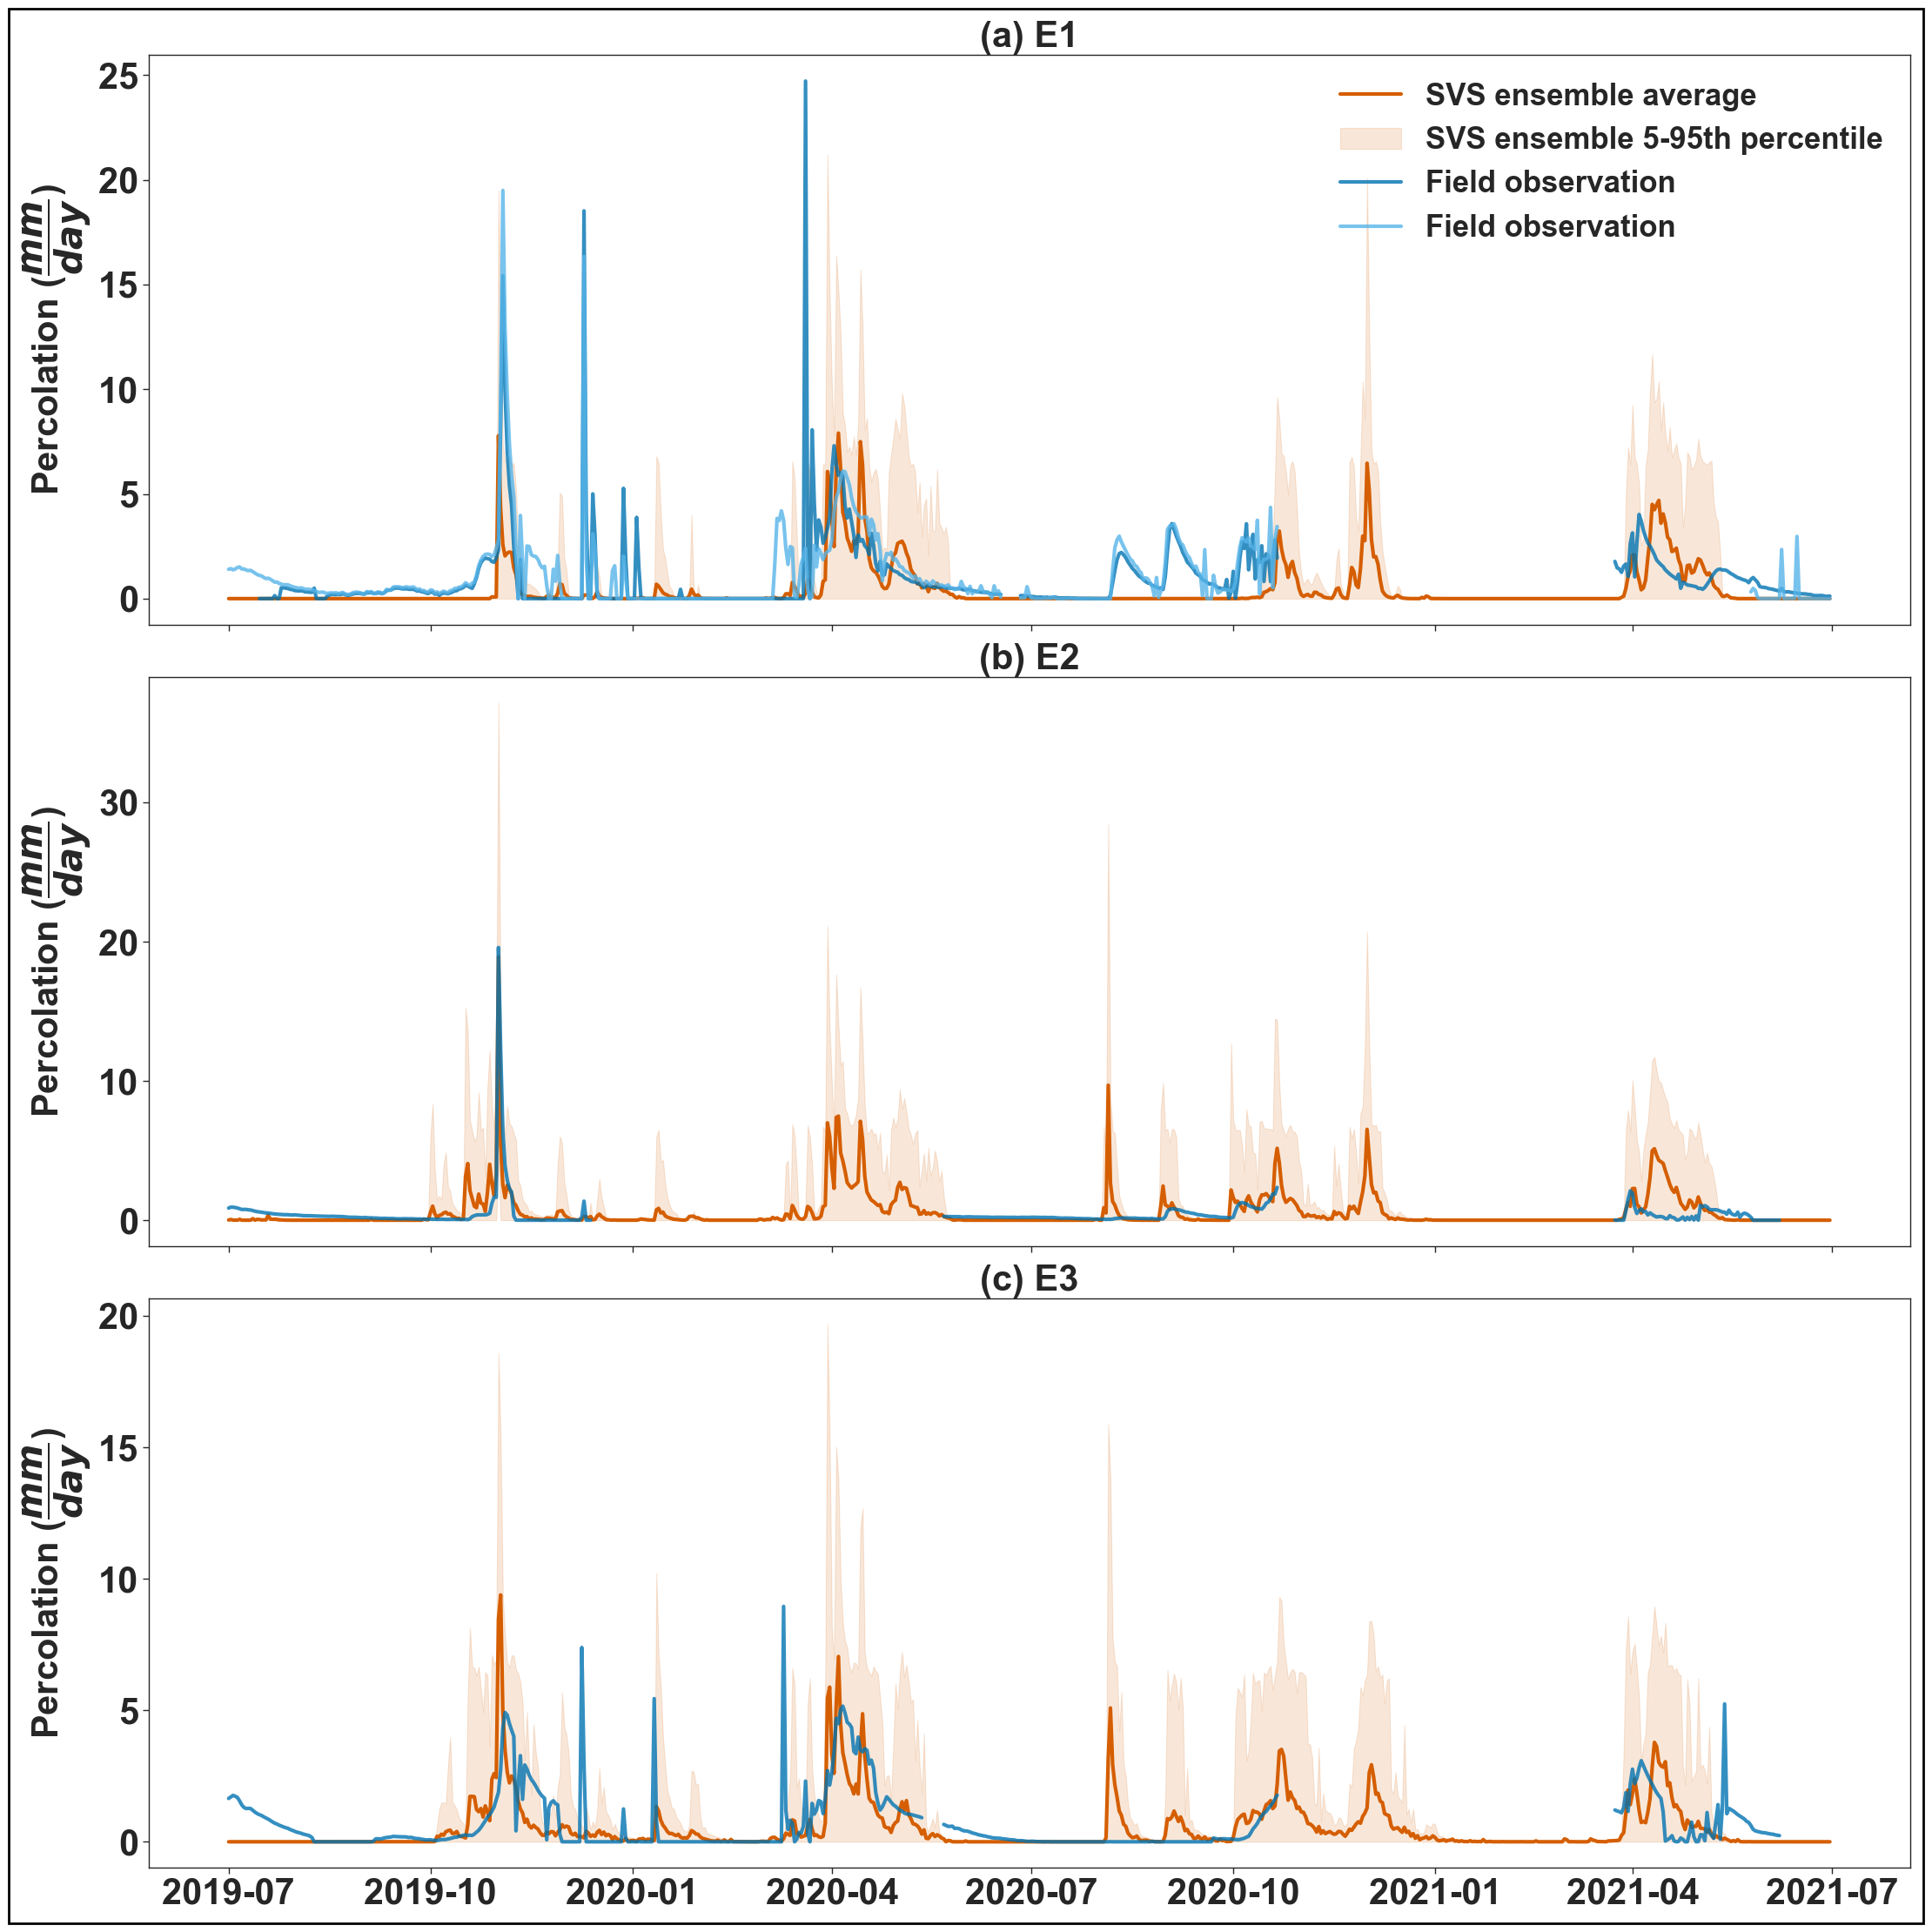

In [98]:


svs_var_name = "DRAI"

# select the columns of interest from the SVS output
sel_cols = [DATE_LABEL, new_enc_label]
sel_cols += [svs_var_name + "_" + agg for agg in ["mean", "min_percentile", "max_percentile"]]

obs_var_name = "Percolation (mm/day)"
obs_src_label = "Lysimeter"

save_fpath = "./output/daily_percolation.pdf"




# plot three subplots on top of each other - each subplot is a different enclosure
# on each, the field percolation is against the ensemble output percolation
fig, ax = plt.subplots(3, 1, figsize=FIG_SIZE, sharex=True)

# Create a Rectangle patch with black edge color
rect = mpatches.Rectangle(
    (0, 0), 1, 1, linewidth=2, edgecolor='black', facecolor='none',
    transform=fig.transFigure, figure=fig
)
# Add the patch to the Axes
fig.patches.extend([rect])


# plot ensemble average: each subplot is a different enclosure
for enc, ax_ in zip(svs_output_agg[new_enc_label].unique(), ax):

    dfplot = pd.merge(
    svs_output_agg.loc[svs_output_agg[new_enc_label] == enc, sel_cols],
    obs_percolation,
    on=[DATE_LABEL, new_enc_label], how="inner"
    )


    sns.lineplot(
        data=dfplot,
        x=DATE_LABEL, y=svs_var_name+"_mean", ax=ax_, color=SVS_COLOR, linewidth=3,
        label="SVS ensemble average"
    )

    # plot min and max percentiles as a shaded area
    ax_.fill_between(
        dfplot[DATE_LABEL],
        dfplot[svs_var_name+"_min_percentile"],
        dfplot[svs_var_name+"_max_percentile"],
        color=SVS_COLOR, alpha=0.15,
        label="SVS ensemble 5-95th percentile"
    )

    # plot field percolation
    obs_srces = dfplot[obs_src_label].unique()
    ax_.plot(
            dfplot.loc[dfplot[obs_src_label] == obs_srces[0], DATE_LABEL], 
            dfplot.loc[dfplot[obs_src_label] == obs_srces[0], obs_var_name], 
            linewidth=3, color=OBS_COLOR, alpha=0.8,
            label="Field observation"
        )
    if len(obs_srces) == 2: 
        ax_.plot(
            dfplot.loc[dfplot[obs_src_label] == obs_srces[1], DATE_LABEL], 
            dfplot.loc[dfplot[obs_src_label] == obs_srces[1], obs_var_name], 
            linewidth=3, color=OBS_COLOR_2, alpha=0.8,
            label="Field observation"
        )
        
    # legend only for the first subplot
    if enc == "E1":
        ax_.legend(fontsize=FONT_SIZE - 5, loc="upper right", frameon=False)
    else:
        ax_.legend().set_visible(False)

    # title : (a) E1, (b) E2, (c) E3
    ax_.set_title(ax_title_map[enc], fontsize=FONT_SIZE, fontweight="bold")
    

# general settings
plt.setp(ax, xlabel="")
plt.setp(ax, ylabel=ax_label_map[obs_var_name])

# set font sizes for all axes
for a in ax:
    a.tick_params(axis="both", which="major", labelsize=FONT_SIZE)
    a.tick_params(axis="both", which="minor", labelsize=FONT_SIZE)
    a.xaxis.label.set_size(FONT_SIZE)
    a.yaxis.label.set_size(FONT_SIZE)
    a.set_rasterized(True)



plt.tight_layout()
plt.gca().patch.set_edgecolor('black')

# save figure: use a black frame around the figure
plt.savefig(save_fpath, dpi=600, bbox_inches="tight", edgecolor="black", facecolor="white")
plt.show()


## plot soil moisture

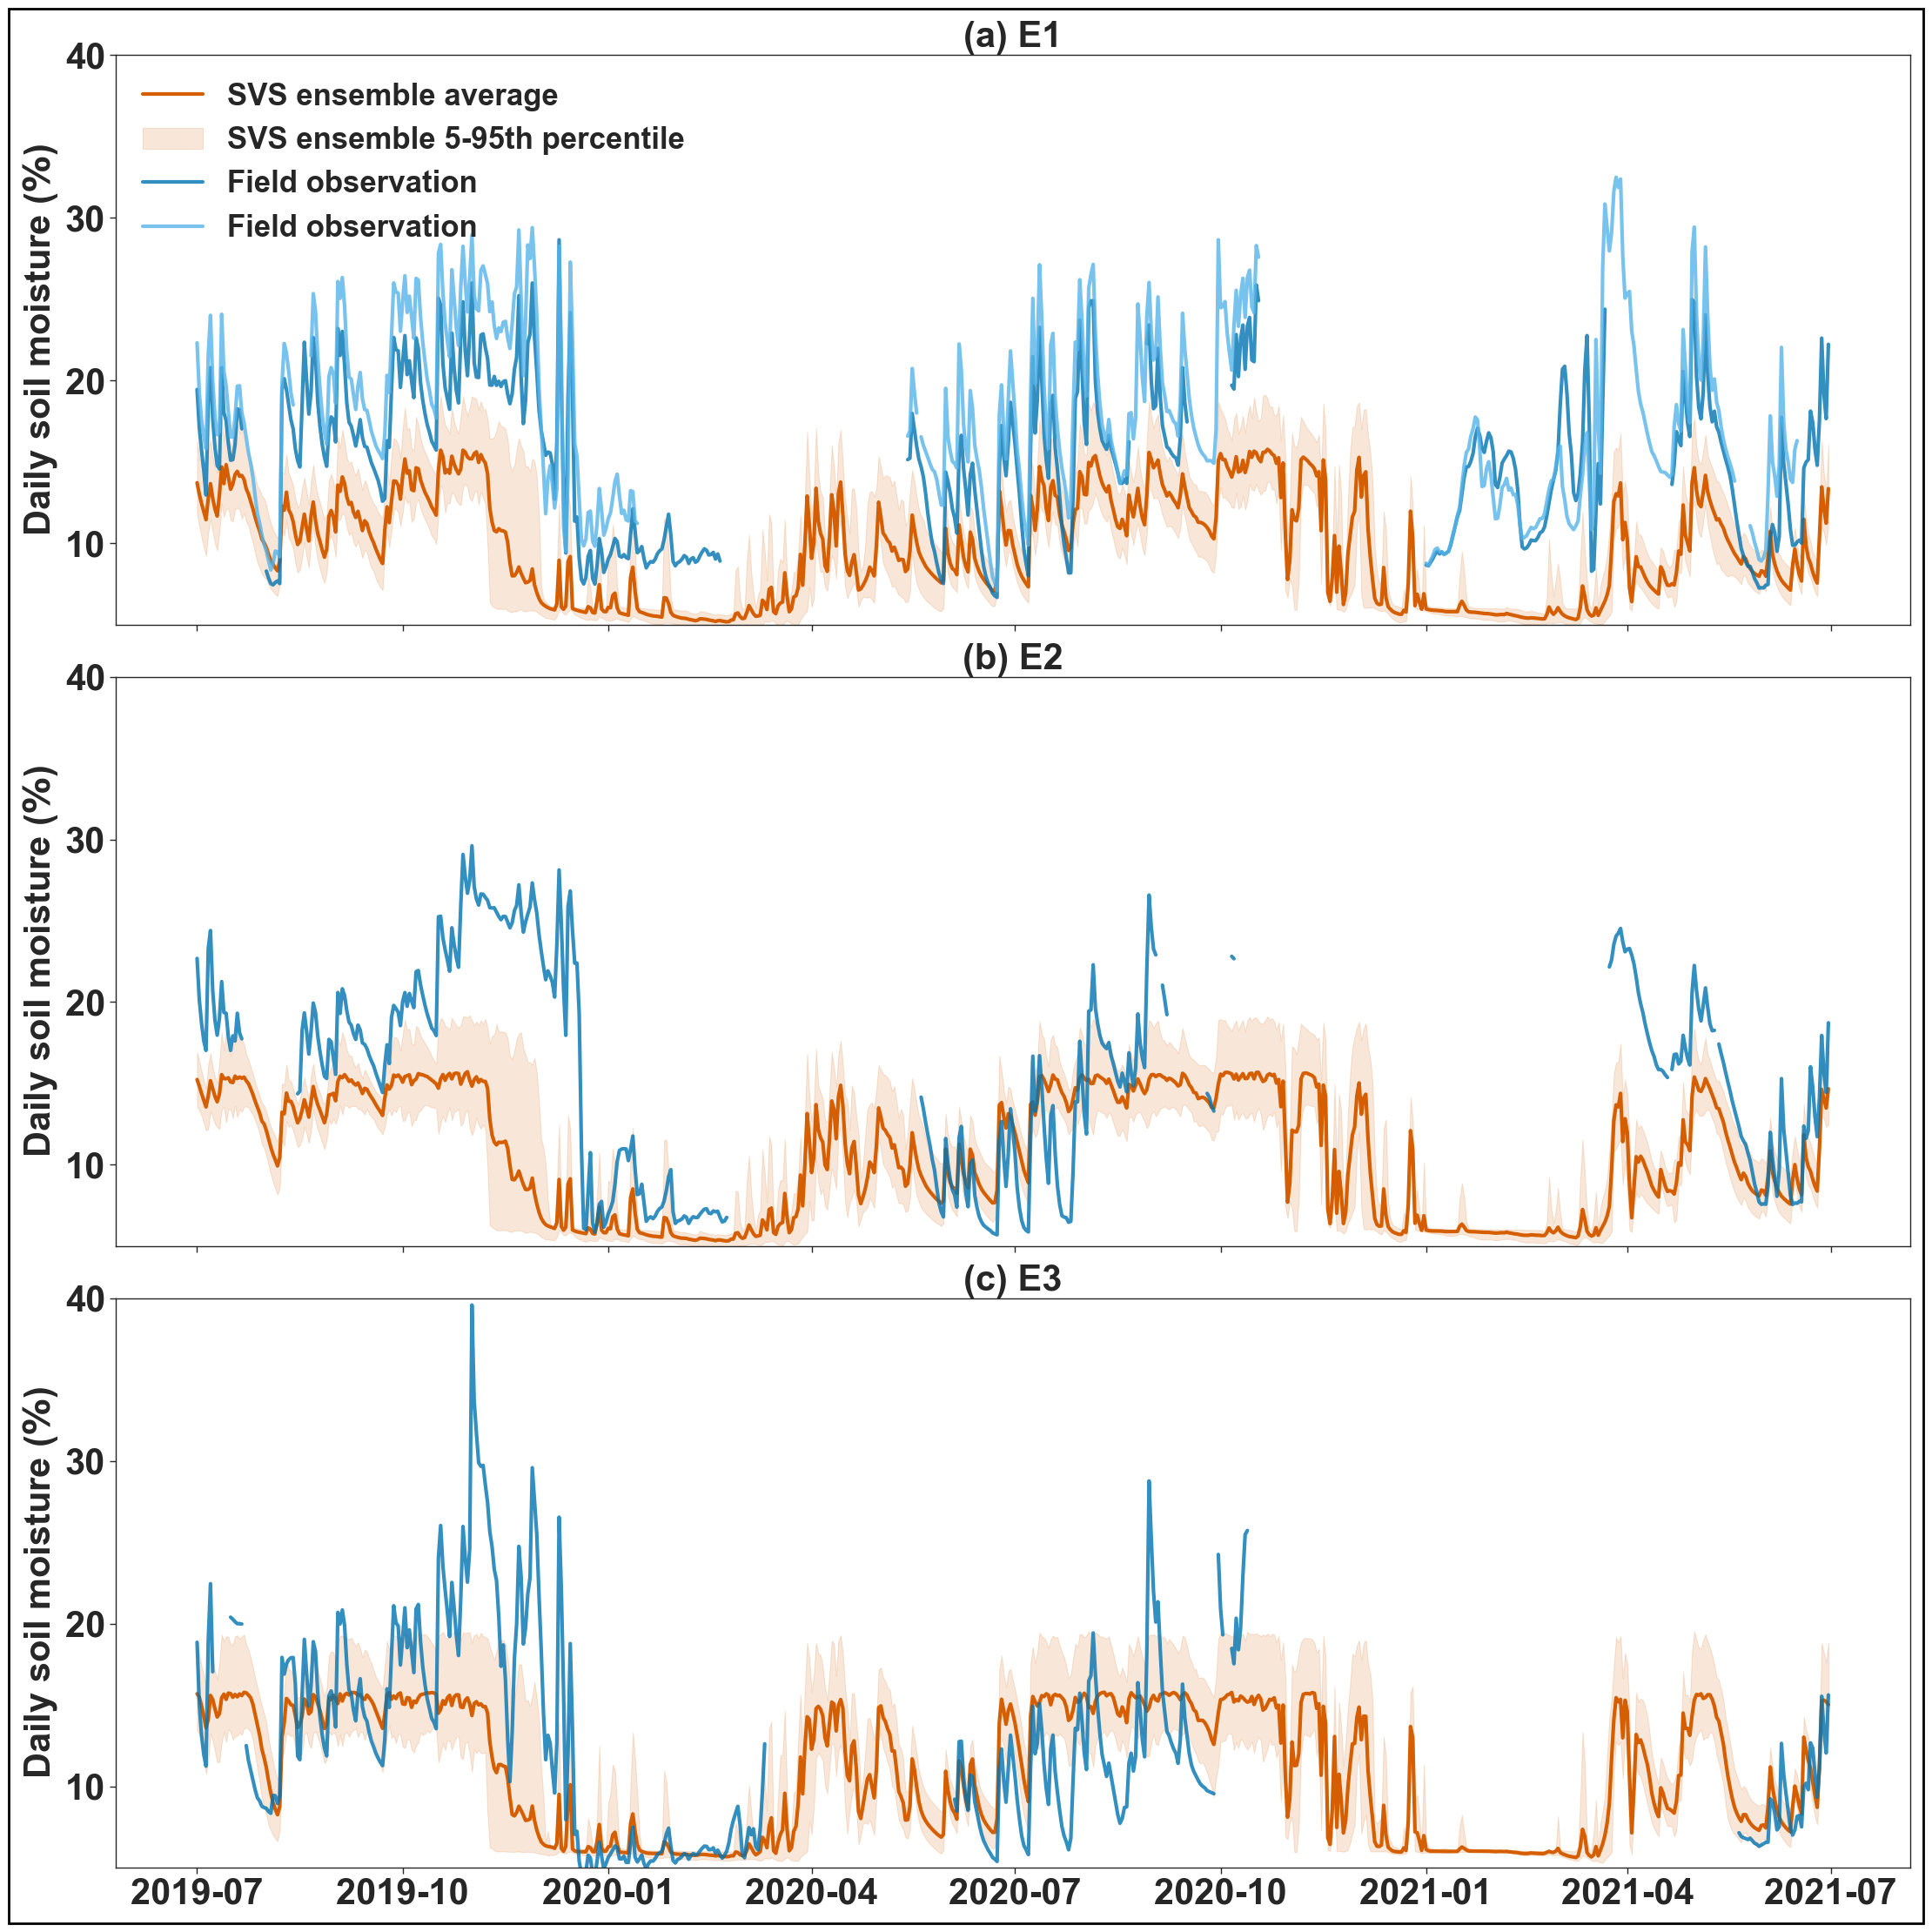

In [97]:


svs_var_name = soil_moist_label

# select the columns of interest from the SVS output
sel_cols = [DATE_LABEL, new_enc_label]
sel_cols += [svs_var_name + "_" + agg for agg in ["mean", "min_percentile", "max_percentile"]]

obs_var_name = "Soil Volumetric Water Content"
obs_src_label = "Sensor"

save_fpath = "./output/daily_moisture_75mmdepth.pdf"




# plot three subplots on top of each other - each subplot is a different enclosure
# on each, the field percolation is against the ensemble output percolation
fig, ax = plt.subplots(3, 1, figsize=FIG_SIZE, sharex=True)

# Create a Rectangle patch with black edge color
rect = mpatches.Rectangle(
    (0, 0), 1, 1, linewidth=2, edgecolor='black', facecolor='none',
    transform=fig.transFigure, figure=fig
)
# Add the patch to the Axes
fig.patches.extend([rect])


# plot ensemble average: each subplot is a different enclosure
for enc, ax_ in zip(svs_output_agg[new_enc_label].unique(), ax):

    dfplot = pd.merge(
    svs_output_agg.loc[svs_output_agg[new_enc_label] == enc, sel_cols],
    obs_soil.loc[obs_soil["Variable"] == obs_var_name, :],
    on=[DATE_LABEL, new_enc_label], how="inner"
    )


    sns.lineplot(
        data=dfplot,
        x=DATE_LABEL, y=svs_var_name+"_mean", ax=ax_, color=SVS_COLOR, linewidth=3,
        label="SVS ensemble average"
    )

    # plot min and max percentiles as a shaded area
    ax_.fill_between(
        dfplot[DATE_LABEL],
        dfplot[svs_var_name+"_min_percentile"],
        dfplot[svs_var_name+"_max_percentile"],
        color=SVS_COLOR, alpha=0.15,
        label="SVS ensemble 5-95th percentile"
    )

    # plot field percolation
    obs_srces = dfplot[obs_src_label].unique()
    ax_.plot(
            dfplot.loc[dfplot[obs_src_label] == obs_srces[0], DATE_LABEL], 
            dfplot.loc[dfplot[obs_src_label] == obs_srces[0], "Value"], 
            linewidth=3, color=OBS_COLOR, alpha=0.8,
            label="Field observation"
        )
    if len(obs_srces) == 2: 
        ax_.plot(
            dfplot.loc[dfplot[obs_src_label] == obs_srces[1], DATE_LABEL], 
            dfplot.loc[dfplot[obs_src_label] == obs_srces[1], "Value"], 
            linewidth=3, color=OBS_COLOR_2, alpha=0.8,
            label="Field observation"
        )
        
    # legend only for the first subplot
    if enc == "E1":
        ax_.legend(fontsize=FONT_SIZE - 5, loc="upper left", frameon=False)
    else:
        ax_.legend().set_visible(False)

    # title : (a) E1, (b) E2, (c) E3
    ax_.set_title(ax_title_map[enc], fontsize=FONT_SIZE, fontweight="bold")
    

# general settings
plt.setp(ax, xlabel="")
plt.setp(ax, ylabel=ax_label_map[obs_var_name])

# set font sizes for all axes
for a in ax:
    a.tick_params(axis="both", which="major", labelsize=FONT_SIZE)
    a.tick_params(axis="both", which="minor", labelsize=FONT_SIZE)
    a.xaxis.label.set_size(FONT_SIZE)
    a.yaxis.label.set_size(FONT_SIZE)
    a.set_rasterized(True)

    # ylims : 5 - 40%
    a.set_ylim(5, 40)

    # yticks : 10, 20, 30, 40
    a.set_yticks([10, 20, 30, 40])



plt.tight_layout()
plt.gca().patch.set_edgecolor('black')

# save figure: use a black frame around the figure
plt.savefig(save_fpath, dpi=600, bbox_inches="tight", edgecolor="black", facecolor="white")
plt.show()

## plot soil temperature

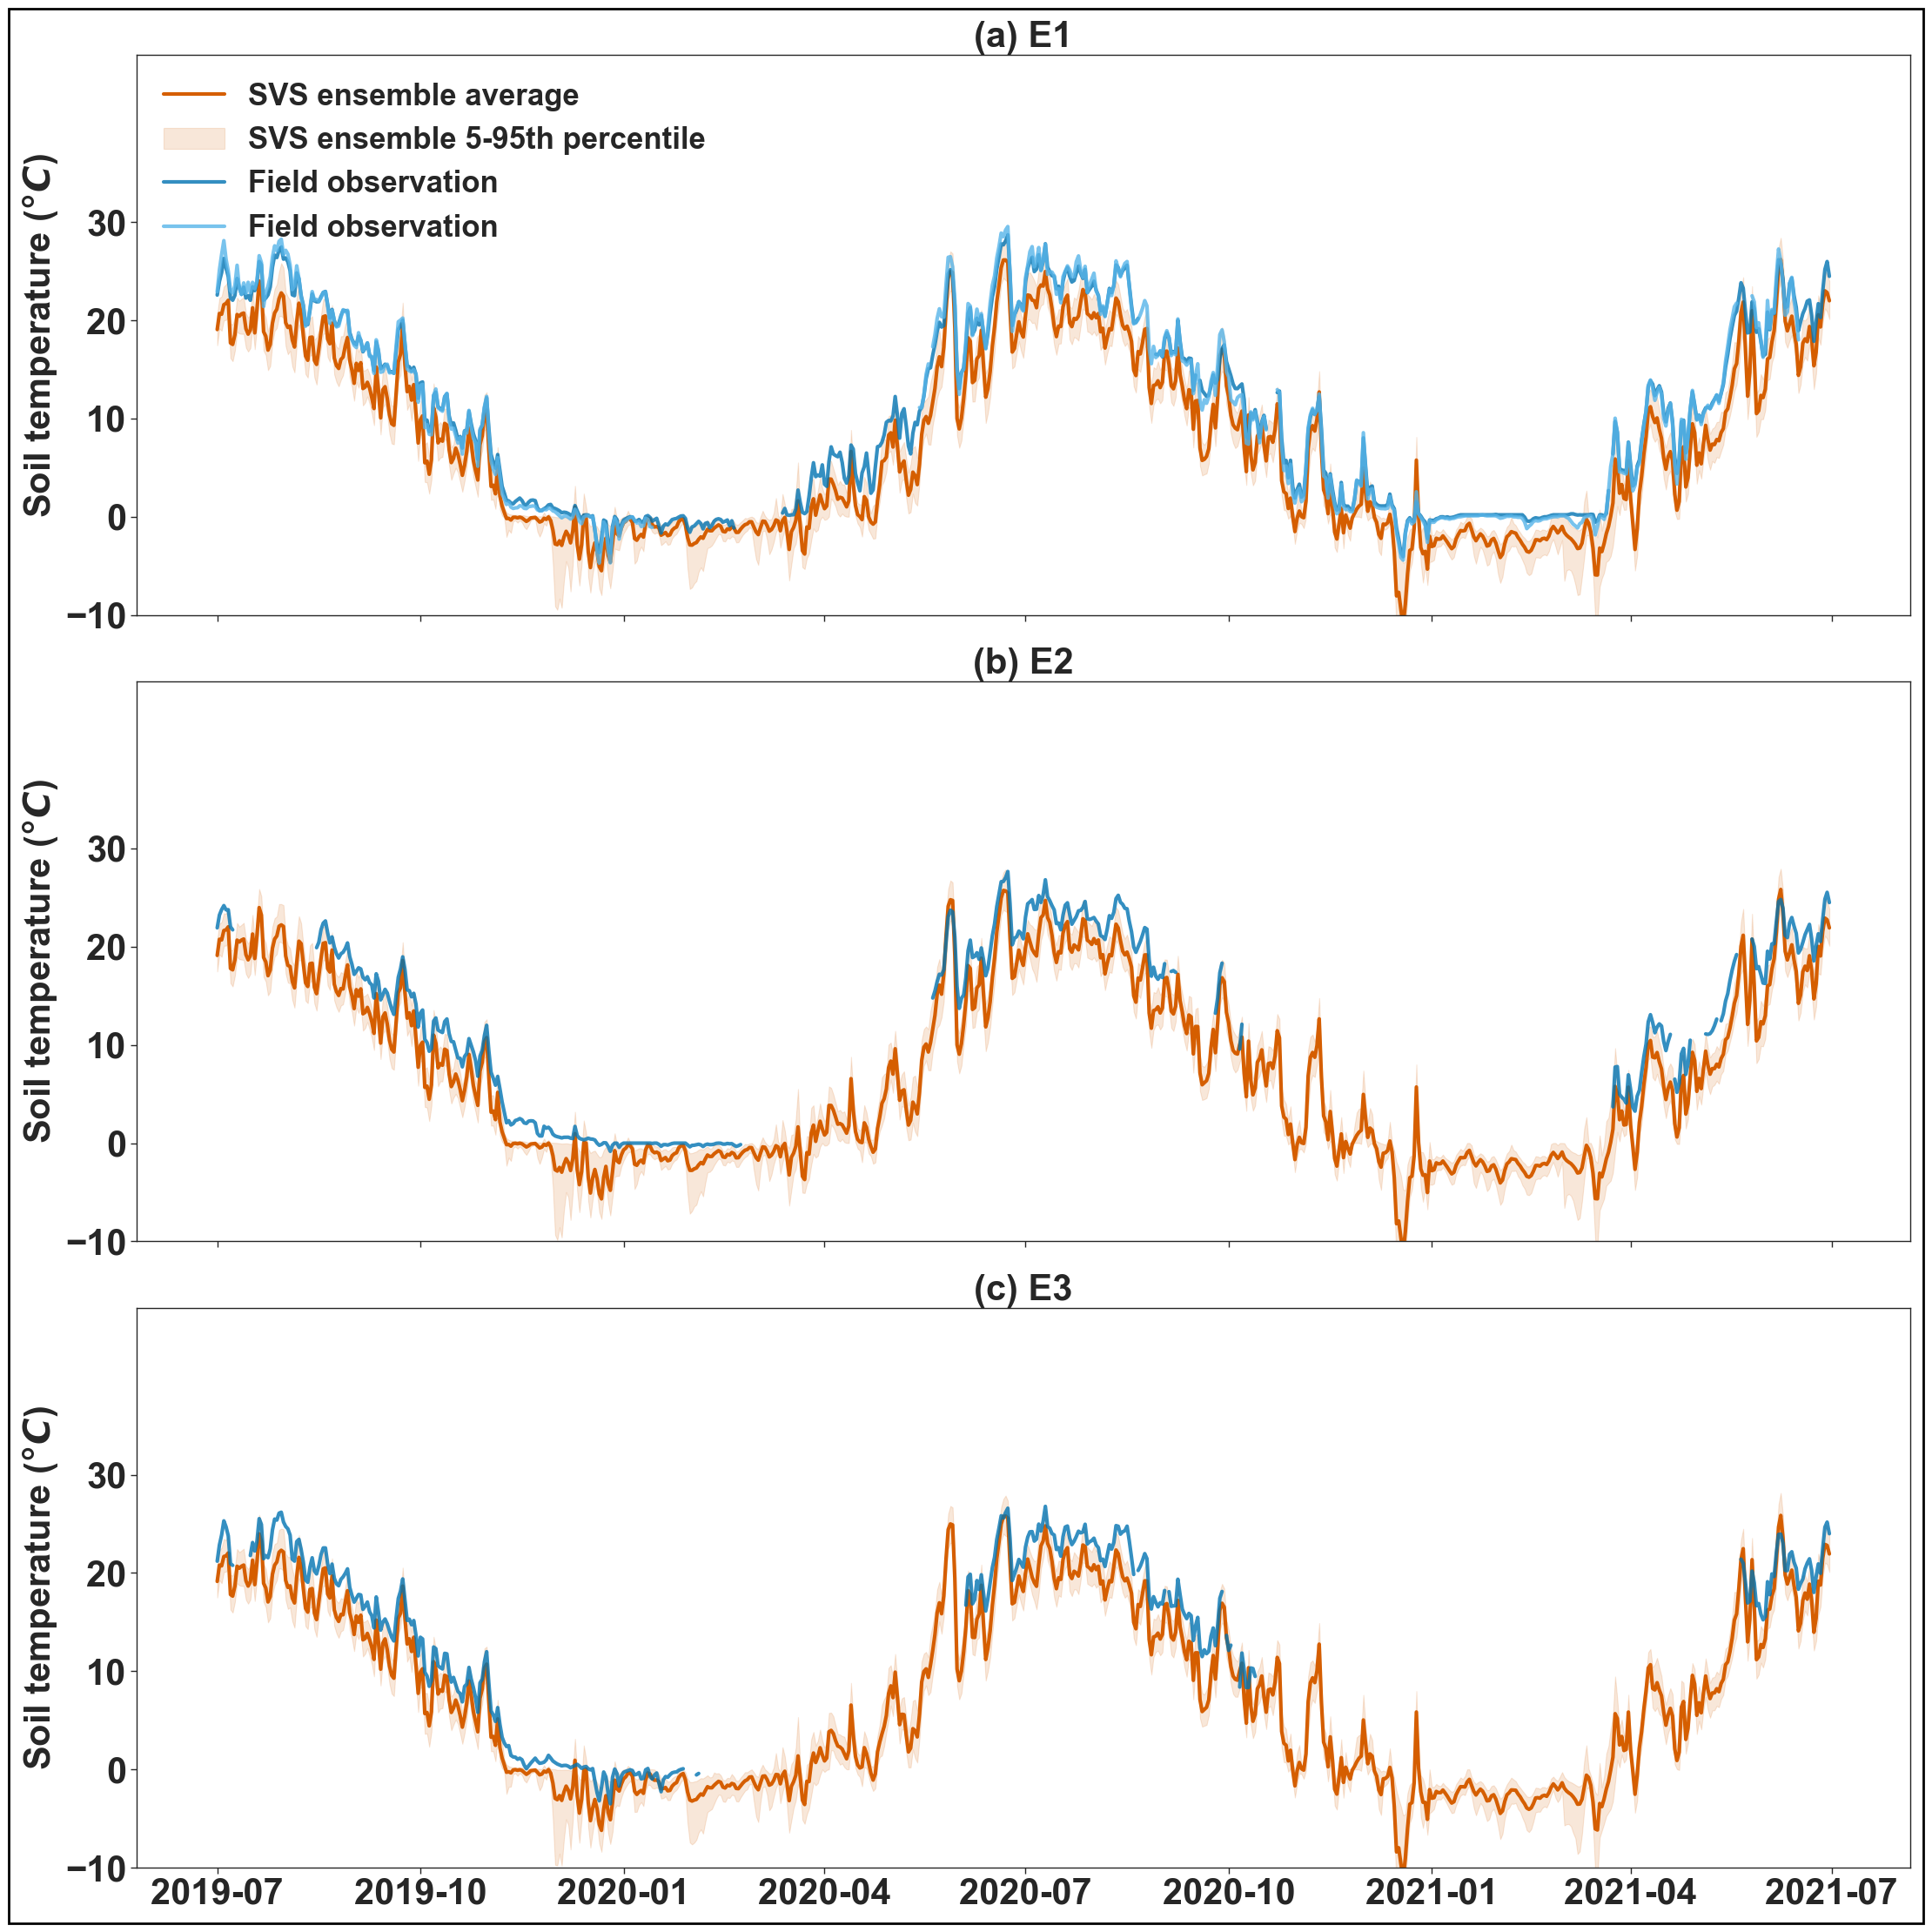

In [100]:


svs_var_name = soil_temp_label

# select the columns of interest from the SVS output
sel_cols = [DATE_LABEL, new_enc_label]
sel_cols += [svs_var_name + "_" + agg for agg in ["mean", "min_percentile", "max_percentile"]]

obs_var_name = "Soil Temperature"
obs_src_label = "Sensor"

save_fpath = "./output/daily_soiltemperature_75mmdepth.pdf"




# plot three subplots on top of each other - each subplot is a different enclosure
# on each, the field percolation is against the ensemble output percolation
fig, ax = plt.subplots(3, 1, figsize=FIG_SIZE, sharex=True)

# Create a Rectangle patch with black edge color
rect = mpatches.Rectangle(
    (0, 0), 1, 1, linewidth=2, edgecolor='black', facecolor='none',
    transform=fig.transFigure, figure=fig
)
# Add the patch to the Axes
fig.patches.extend([rect])


# plot ensemble average: each subplot is a different enclosure
for enc, ax_ in zip(svs_output_agg[new_enc_label].unique(), ax):

    dfplot = pd.merge(
    svs_output_agg.loc[svs_output_agg[new_enc_label] == enc, sel_cols],
    obs_soil.loc[obs_soil["Variable"] == obs_var_name, :],
    on=[DATE_LABEL, new_enc_label], how="inner"
    )


    sns.lineplot(
        data=dfplot,
        x=DATE_LABEL, y=svs_var_name+"_mean", ax=ax_, color=SVS_COLOR, linewidth=3,
        label="SVS ensemble average"
    )

    # plot min and max percentiles as a shaded area
    ax_.fill_between(
        dfplot[DATE_LABEL],
        dfplot[svs_var_name+"_min_percentile"],
        dfplot[svs_var_name+"_max_percentile"],
        color=SVS_COLOR, alpha=0.15,
        label="SVS ensemble 5-95th percentile"
    )

    # plot field percolation
    obs_srces = dfplot[obs_src_label].unique()
    ax_.plot(
            dfplot.loc[dfplot[obs_src_label] == obs_srces[0], DATE_LABEL], 
            dfplot.loc[dfplot[obs_src_label] == obs_srces[0], "Value"], 
            linewidth=3, color=OBS_COLOR, alpha=0.8,
            label="Field observation"
        )
    if len(obs_srces) == 2: 
        ax_.plot(
            dfplot.loc[dfplot[obs_src_label] == obs_srces[1], DATE_LABEL], 
            dfplot.loc[dfplot[obs_src_label] == obs_srces[1], "Value"], 
            linewidth=3, color=OBS_COLOR_2, alpha=0.8,
            label="Field observation"
        )
        
    # legend only for the first subplot
    if enc == "E1":
        ax_.legend(fontsize=FONT_SIZE - 5, loc="upper left", frameon=False)
    else:
        ax_.legend().set_visible(False)

    # title : (a) E1, (b) E2, (c) E3
    ax_.set_title(ax_title_map[enc], fontsize=FONT_SIZE, fontweight="bold")
    

# general settings
plt.setp(ax, xlabel="")
plt.setp(ax, ylabel=ax_label_map[obs_var_name])

# set font sizes for all axes
for a in ax:
    a.tick_params(axis="both", which="major", labelsize=FONT_SIZE)
    a.tick_params(axis="both", which="minor", labelsize=FONT_SIZE)
    a.xaxis.label.set_size(FONT_SIZE)
    a.yaxis.label.set_size(FONT_SIZE)
    a.set_rasterized(True)

    # ylims : -10 - 45 degC
    a.set_ylim(-10, 47)

    # yticks: -10, 0, 10, 20, 30
    a.set_yticks([-10, 0, 10, 20, 30])



plt.tight_layout()
plt.gca().patch.set_edgecolor('black')

# save figure: use a black frame around the figure
plt.savefig(save_fpath, dpi=600, bbox_inches="tight", edgecolor="black", facecolor="white")
plt.show()

## plot snow depth

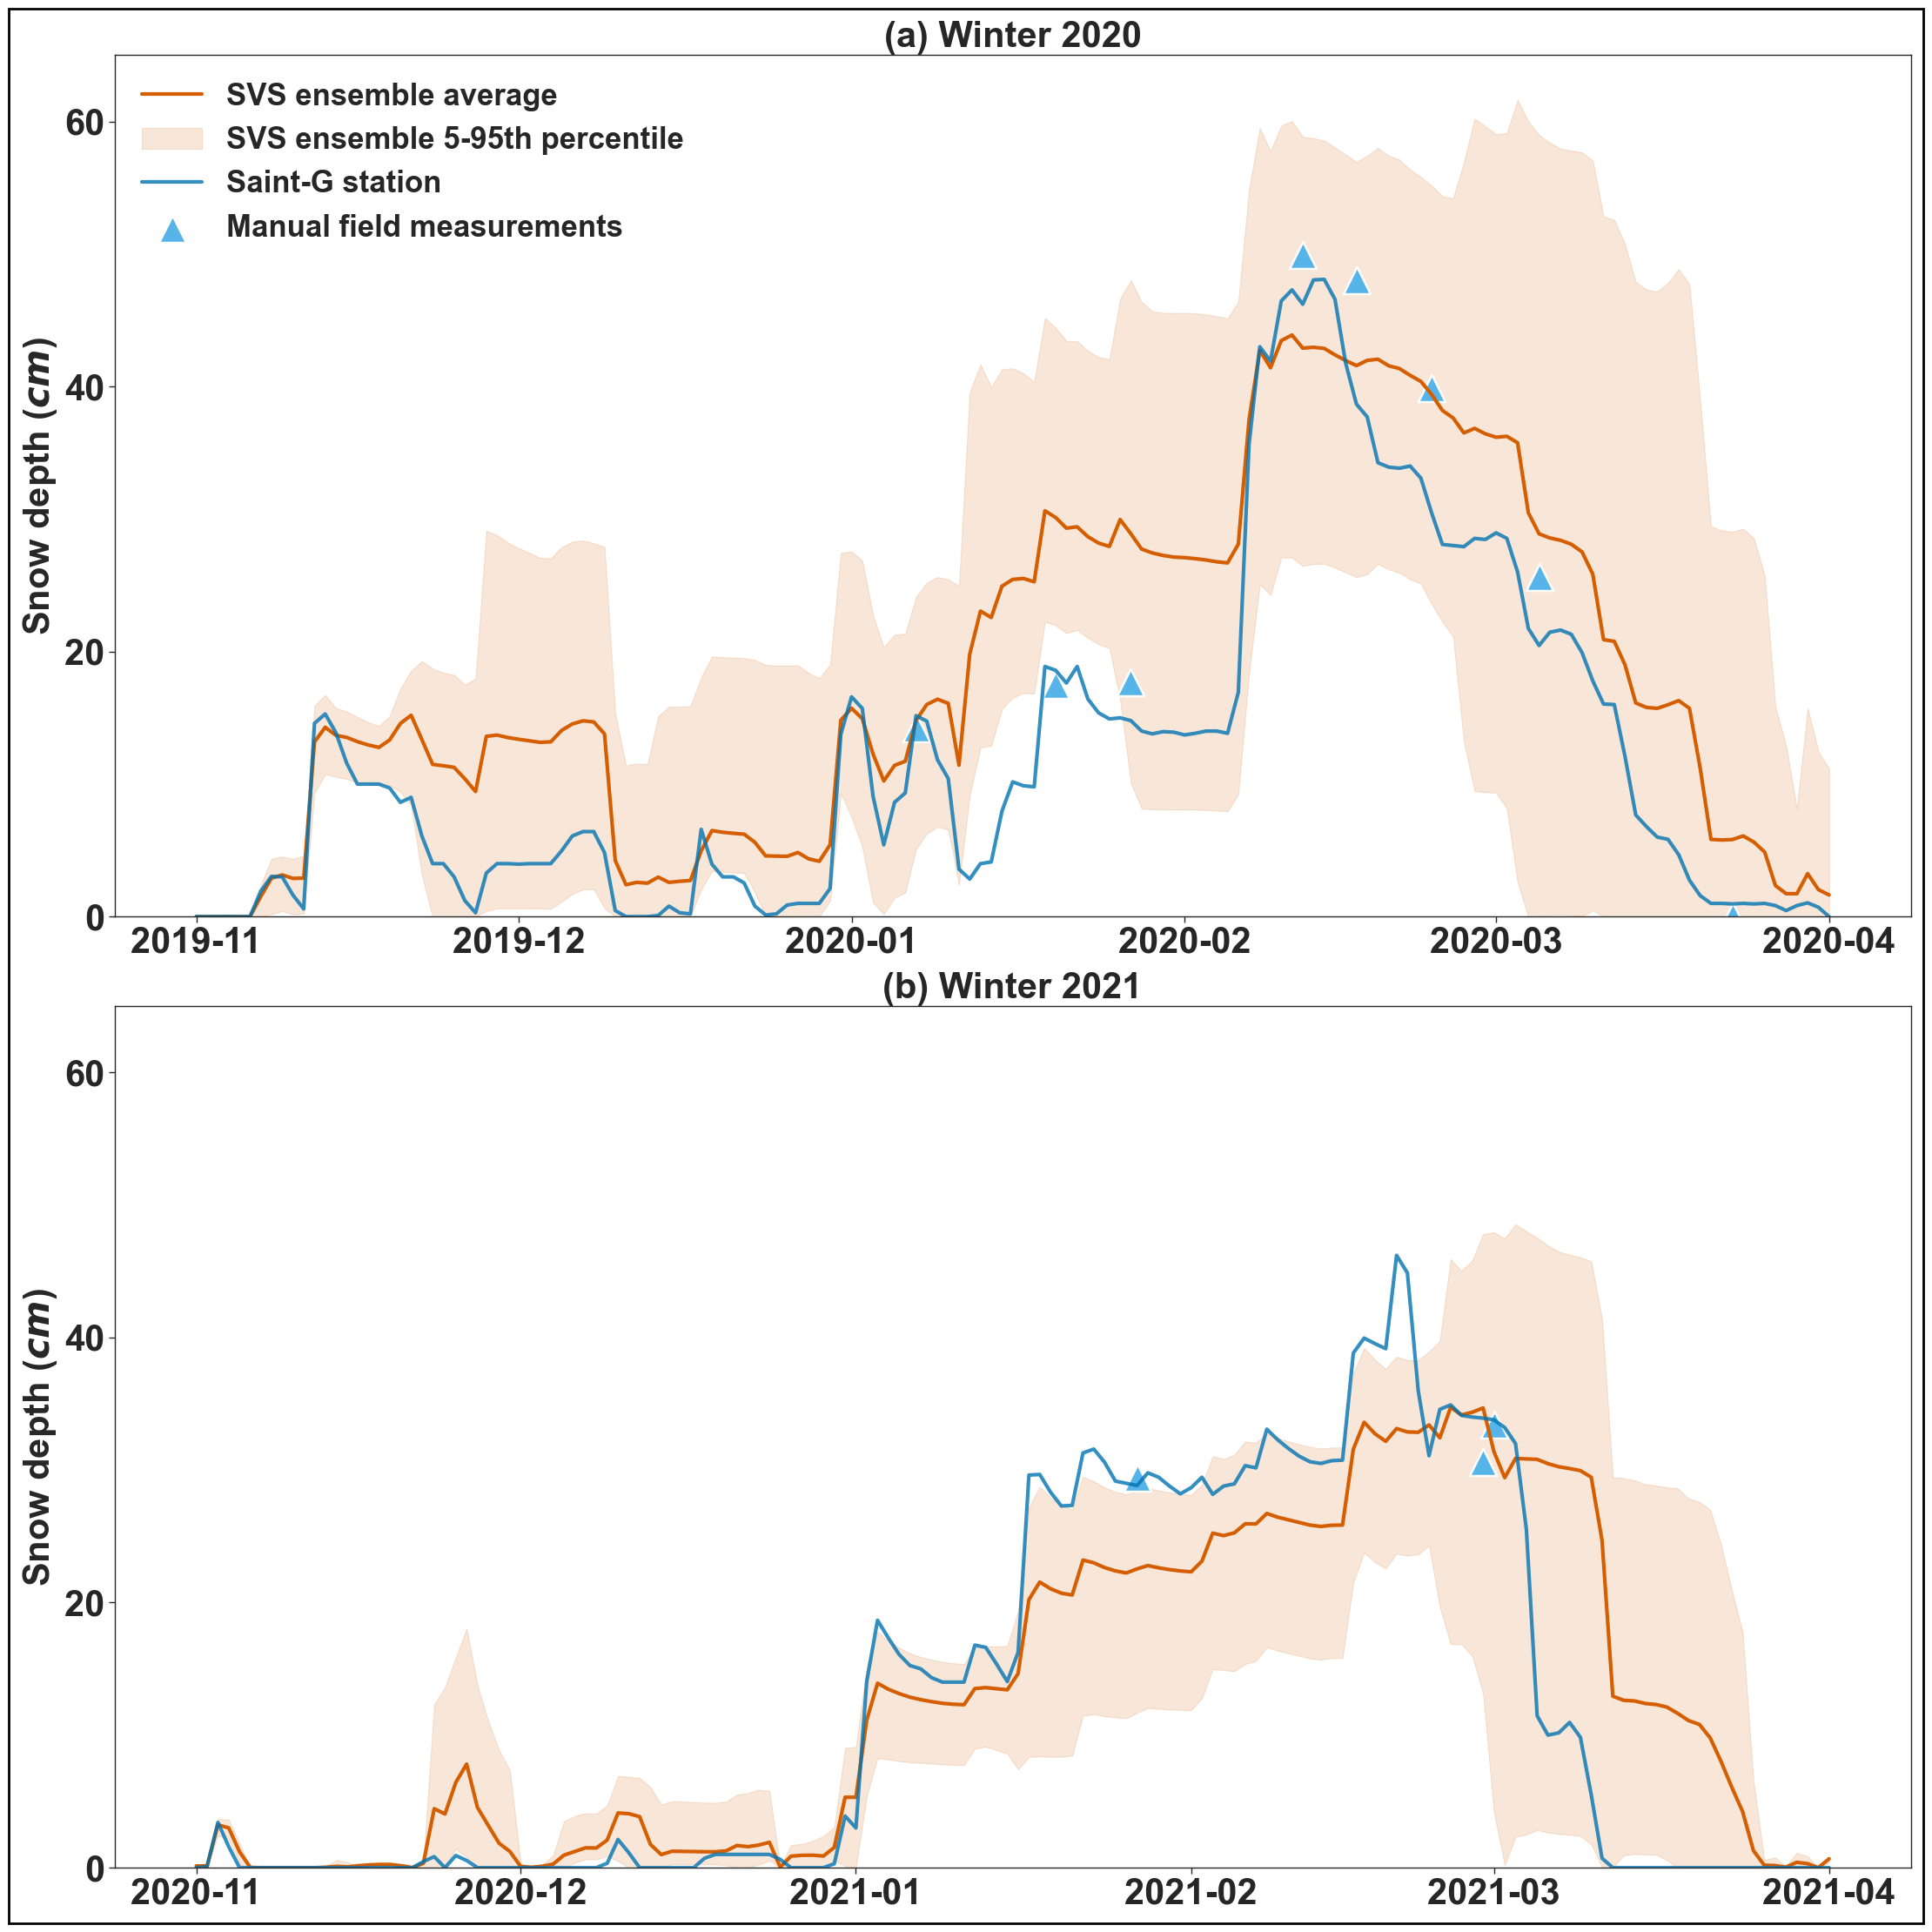

In [129]:
svs_var_name = "SNODP"

# select the columns of interest from the SVS output
sel_cols = [DATE_LABEL, new_enc_label]
sel_cols += [svs_var_name + "_" + agg for agg in ["mean", "min_percentile", "max_percentile"]]

# obs from saint-g station
eccc_obs_var_name = "Snow depth (cm)"

# manual obs from the field
field_obs_src_label = "Field snow depth (cm)"

save_fpath = "./output/daily_snowdepth.pdf"

# plot three subplots on top of each other - each subplot is a different winter
fig, ax = plt.subplots(2, 1, figsize=FIG_SIZE, sharex=False)

# Create a Rectangle patch with black edge color
rect = mpatches.Rectangle(
    (0, 0), 1, 1, linewidth=2, edgecolor='black', facecolor='none',
    transform=fig.transFigure, figure=fig
)
# Add the patch to the Axes
fig.patches.extend([rect])

dfplot = pd.merge(
    # only needed for one plot, since snow simulation is the same for all enclosures
    svs_output_agg.loc[svs_output_agg["Experimental Plot"] == "E3", sel_cols],
    obs_meteo.loc[:, [DATE_LABEL, eccc_obs_var_name, field_obs_src_label]],
    on=DATE_LABEL, how="inner"
)

# create winter column using `first_winter` and `second_winter` datetime arrays
dfplot["winter"] = None
dfplot.loc[dfplot[DATE_LABEL].isin(first_winter), "winter"] = "first"
dfplot.loc[dfplot[DATE_LABEL].isin(second_winter), "winter"] = "second"

# renmove rows with winter == None
dfplot = dfplot.loc[dfplot["winter"].notnull(), :]

for ax_, win in zip(ax, dfplot["winter"].unique()):
    
    dfplot_ = dfplot.loc[dfplot["winter"] == win, :]

    sns.lineplot(
        data=dfplot_,
        x=DATE_LABEL, y=svs_var_name+"_mean", ax=ax_, color=SVS_COLOR, linewidth=3,
        label="SVS ensemble average"
    )

    # plot min and max percentiles as a shaded area
    ax_.fill_between(
        dfplot_[DATE_LABEL],
        dfplot_[svs_var_name+"_min_percentile"],
        dfplot_[svs_var_name+"_max_percentile"],
        color=SVS_COLOR, alpha=0.15,
        label="SVS ensemble 5-95th percentile"
    )

    # snow depth from saint-g station
    ax_.plot(
            dfplot_.loc[:, DATE_LABEL], 
            dfplot_.loc[:, eccc_obs_var_name],
            linewidth=3, color=OBS_COLOR, alpha=0.8,
            label="Saint-G station"
    )

    # manual snow depth from the field
    sns.scatterplot(
    data=dfplot_, x=DATE_LABEL, y=field_obs_src_label, ax=ax_, 
    color=OBS_COLOR_2, s=MRK_SIZE, marker="^", label="Manual field measurements"
    )

    # legend only for the first subplot
    if win == "first":
        ax_.legend(fontsize=FONT_SIZE - 5, loc="upper left", frameon=False)
        ax_.set_title("(a) Winter 2020", fontsize=FONT_SIZE, fontweight="bold")
    else:
        ax_.legend().set_visible(False)
        ax_.set_title("(b) Winter 2021", fontsize=FONT_SIZE, fontweight="bold")


# general settings
plt.setp(ax, xlabel="")
plt.setp(ax, ylabel=ax_label_map[eccc_obs_var_name])

# set font sizes for all axes
for a in ax:
    a.tick_params(axis="both", which="major", labelsize=FONT_SIZE)
    a.tick_params(axis="both", which="minor", labelsize=FONT_SIZE)
    a.xaxis.label.set_size(FONT_SIZE)
    a.yaxis.label.set_size(FONT_SIZE)
    a.set_rasterized(True)

    # ylims : 5 - 40%
    a.set_ylim(0, 65)

    # yticks : 10, 20, 30, 40
    a.set_yticks([0, 20, 40, 60])



plt.tight_layout()
plt.gca().patch.set_edgecolor('black')

# save figure: use a black frame around the figure
plt.savefig(save_fpath, dpi=600, bbox_inches="tight", edgecolor="black", facecolor="white")
plt.show()

In [133]:
SVS_COLOR

(0.8352941176470589, 0.3686274509803922, 0.0)